In [1]:
import matplotlib
matplotlib.use('Qt5Agg')
import numpy as np
import matplotlib.pyplot as plt
import Markov_Models as mm
from scipy import stats
from scipy import interpolate
from scipy import spatial
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error

/home/ebeyerle/bin/anaconda3/lib/python3.5/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.1, you have 2.4.
  .format(latest=latest, current=current), category=UserWarning)


In [ ]:
#Do a little ZTS to get a good starting configuration
path="/home/ebeyerle/Desktop/PCA/UBQN/400ns/"
os.chdir(path)
bins=50
xx,yy=np.meshgrid(np.linspace(0,180,bins),np.linspace(0,360,bins))
#mode=1
nfrs=1
nframes=50
barlist=[]
pointslist=[]
for mode in range(1,2):
    with open(path+'anly_'+str(mode)+'.dat','r') as data:
        x=[]
        y=[]
        for line in data:
            nfrs=nfrs+1
            p=line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))
    print(nfrs)
    data=[np.column_stack([x,y])]
    model = mm.MSM(data)
    his0 = model.histogram(0, bins=50)
    his1 = model.histogram(1, bins=50)
    his = model.histogram(bins=50)
    ext=model.extent
    lst=np.zeros(bins*bins)
    chk=his.T/his.sum()
    counter=-1
    for i in range(len(chk[0,:])):
        for j in range(len(chk[:,0])):
            counter=counter+1
            lst[counter]=chk[i][j]
    counter=0
    fes=np.zeros((bins,bins))
    for i in range(len(chk[0,:])):
        for j in range(len(chk[:,0])):
            if (lst[counter] <= 0):
                fes[i][j]=-np.log(1/nfrs)
                counter=counter+1
            else:
                fes[i][j]=-np.log(lst[counter])
                counter=counter+1
    min1=np.min(fes)
    for i in range(bins):
        for j in range(bins):
            fes[i][j]=fes[i][j]-min1
    #plt.contourf(xx,yy,fes, 25, cmap='gnuplot')
    #plt.show()
    theta=np.linspace(0,180,bins)
    phi=np.linspace(0,360,bins)
    #Smooth the surface with k-nearest neighbors
    n_values = 100
    alpha = 2

    x0, x1 = np.meshgrid(theta,phi)
    X = np.column_stack([x0.ravel(), x1.ravel()])
    score = []
    for n_neighbor in np.arange(alpha, n_values * alpha + 1, alpha):
        for train_index, test_index in ShuffleSplit(n_splits=1, test_size=0.40, random_state=24).split(X):
            X_train, y_train = X[train_index], fes.ravel()[train_index]
            X_test, y_test = X[test_index], fes.ravel()[test_index]

        knn = KNeighborsRegressor(n_neighbors=n_neighbor).fit(X_train, y_train)
        score.append(mean_squared_error(knn.predict(X_test), y_test))
    if np.argmin(score) == 0:
        n_neighbors=2
        print("Hmm... no nearest neighbors. Setting k:=1.")
    else:
        n_neighbors = np.argmin(score) * alpha        
    print("k = {:d}".format(np.argmin(score)))
    knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, fes.ravel())
    fes_knn = knn.predict(X).reshape(bins, bins)
    dVy,dVx=np.gradient(fes_knn)
    dVx=interpolate.interp2d(theta,phi,dVx,kind='quintic')
    dVy=interpolate.interp2d(theta,phi,dVy,kind='quintic')
    plt.close()
    plt.contourf(xx,yy,fes,cmap='gnuplot')
    plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
    #plt.show()
    #Now convert the code from the ZTS Matlab code
    tol1=0.00001 #Convergence criterion
    tollist=[]
    flag1=1
    nstepplot=100
    nstep=1000
    g1=np.linspace(0,1,nframes)
    #Perform the interpolation; same as above
    min1=np.where(fes == 0.0)
    ya=min1[0][0]
    xa=min1[1][0]
    xb=140
    yb=300
    x=(xb-xa)*g1+xa
    y=(x-xa)*(yb-ya)/(xb-xa)+ya
    dx=x-np.roll(x,1,axis=0)
    dy=y-np.roll(y,1,axis=0)
    dx[0]=0
    dy[0]=0
    lxy=np.cumsum(np.sqrt(dx**2+dy**2))
    lxy=lxy/lxy[nframes-1]
    #Honestly not sure why these two lines are here; the x, y that are returned
    #are identical to the x, y generated by the linear interpolation.
    x=interpolate.interp1d(lxy,x)(g1)
    y=interpolate.interp1d(lxy,y)(g1)
    xi=x
    yi=y
    #plt.plot(xi,yi,'w',lw=1)
    plt.scatter(xi,yi,marker='x',c='w')
    plt.plot(x,y,'b')
    counter=1
    #plt.savefig("/home/ebeyerle/Desktop/fifty_fes_animate_mode"+str(mode)+"frame00"+str(counter)+".jpeg")
    plt.close()
    #plt.show()
    laplist=[]
    grady,gradx=np.gradient(fes_knn)
    lapxy,lapxx=np.gradient(gradx)
    lapyy,lapyx=np.gradient(grady)
    h=1/(np.array([lapxx.max(),lapxy.max(),lapyx.max(),lapyy.max()]).max())
    #h=0.1#Just a parameter -- proabably need to adjust to get good convergence
    print('h=',h)
    for i in range(nstep):
        dVy,dVx=np.gradient(fes_knn)
        dVx=interpolate.interp2d(theta,phi,dVx,kind='quintic')
        dVy=interpolate.interp2d(theta,phi,dVy,kind='quintic')
        x0=x
        y0=y
        # Evolve the string using steepest descent
        for j in range(len(x)):
            x[j]=x[j]-h*dVx(x[j],y[j])[0]
            y[j]=y[j]-h*dVy(x[j],y[j])[0]
            #Enforce PBCs
            #KLUDGE: Not letting them cross for now
            if y[j] <=0.0: 
                y[j]=0.0
            if y[j] >=360.0:
                y[j]=360.0
            if x[j] <=0.0:
                x[j] = 0.0
            if x[j] >= 180.0:
                x[j]=180.0
        #Reparameterize
        dx=x-np.roll(x,1,axis=0)
        dy=y-np.roll(y,1,axis=0)
        dx[0]=0
        dy[0]=0
        #Find the string length...
        lxy=np.cumsum(np.sqrt(dx**2+dy**2))
        lxy=lxy/lxy[nframes-1]
        #...and place each state at an equally-spaced length along the string
        x=interpolate.interp1d(lxy,x)(g1)
        y=interpolate.interp1d(lxy,y)(g1)
        if flag1 == 1 and i%nstepplot == 0:
            counter=counter+1
            #plt.plot(x,y)
            if counter < 10:
                plt.contourf(xx,yy,fes,cmap='gnuplot')
                plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
                plt.scatter(x,y,marker='o',c='w')
                plt.plot(x,y,'b')
                #plt.savefig("/home/ebeyerle/Desktop/fifty_fes_animate_mode"+str(mode)+"frame00"+str(counter)+".jpeg")
                plt.close()
            elif counter >= 10 and counter <100:
                plt.contourf(xx,yy,fes,cmap='gnuplot')
                plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
                plt.scatter(x,y,marker='o',c='w')
                plt.plot(x,y,'b')
                #plt.savefig("/home/ebeyerle/Desktop/fifty_fes_animate_mode"+str(mode)+"frame0"+str(counter)+".jpeg")
                plt.close()
            else:
                plt.contourf(xx,yy,fes,cmap='gnuplot')
                plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
                plt.scatter(x,y,marker='o',c='w')
                plt.plot(x,y,'b')
                #plt.savefig("/home/ebeyerle/Desktop/fifty_fes_animate_mode"+str(mode)+"frame"+str(counter)+".jpeg")
                plt.close()
        #    plt.show()
        tol=(np.linalg.norm(x-x0)+np.linalg.norm(y-y0))/(nframes)
        tollist.append(tol)
        #if len(tollist) >=3:
        #    if tollist[i-3]-tollist[i] == 0:
        #        print('converged')
        #        break
        if tol <= tol1: #Has the string converged?
            break #It has converged!
        if i%nstepplot == 0:
            print(tol)
    print('\n')
    print('\n')
    print('ZTS calculation with ',nframes,' images.\n')
    if tol >= tol1:
        print('The method did not converge in ',nstep,' steps.')
    else:
        print('The method converged after ',nstep,' steps.')
    #plt.plot(x,y)
    plt.contourf(xx,yy,fes,cmap='gnuplot')
    plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
    plt.scatter(x,y,marker='o',c='w')
    plt.plot(x,y,'b')
    plt.show()


1785715
h= 0.478694437825
0.169771010145
0.418488027664
0.287430330746
0.188684200806
0.377262095391
0.236687496184
0.240312685339
0.250302480252
0.185105501291
0.331943523455




FTS calculation with  50  images.

The method did not converge in  10000  steps.


Barrier Height ($k_BT$):  3.88084918389
3571429
h= 0.577077969733
0.315683384105
0.157377048542
0.255902002942
0.250234721265
0.334424216832
0.238731339323
0.233821084044
0.350874902405
0.197184657283
0.287915203945




FTS calculation with  50  images.

The method did not converge in  10000  steps.


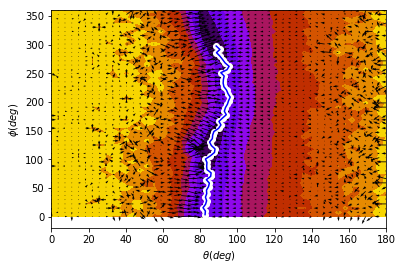



Barrier Height ($k_BT$):  2.3978644545
5357143
h= 0.752649901062
0.350354732219
0.230425264588
0.403500222709
0.291667471576
0.271936626497
0.565320015181
0.270338390899
0.666883167715
0.310303152698
0.37644717287




FTS calculation with  50  images.

The method did not converge in  10000  steps.


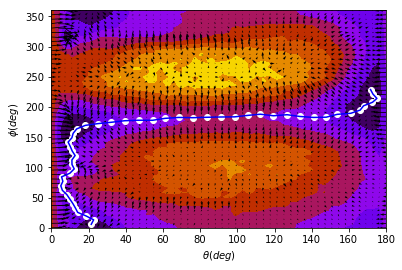



Barrier Height ($k_BT$):  2.55071917386
7142857
h= 1.52880901523
0.323767169468
0.332729275449
0.523612305235
0.344802202836
0.807119918994
0.447200601454
0.492891559976
1.44399049156
0.384579267023
0.494967573675




FTS calculation with  50  images.

The method did not converge in  10000  steps.


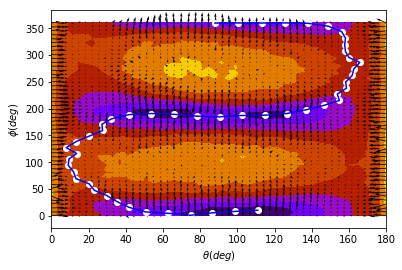



Barrier Height ($k_BT$):  3.56141276877
8928571
h= 1.27275863887
0.44059816057
0.54860034103
0.81476875859
0.561712586237
0.353360913459
0.46418122968
0.417921982578
0.461891309748
0.943936297946
0.720050521931




FTS calculation with  50  images.

The method did not converge in  10000  steps.


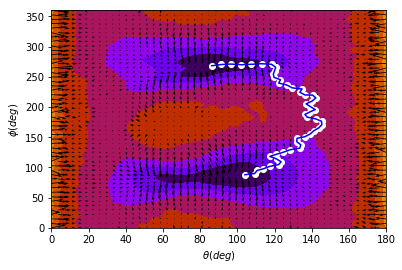



Barrier Height ($k_BT$):  3.57446076562
10714285
h= 0.857313179547
0.292647015788
0.347917684869
0.300316527758
0.615423853391
0.296962278751
0.309929775576
0.304008750353
0.428827463593
0.288319084868
0.644965475765




FTS calculation with  50  images.

The method did not converge in  10000  steps.


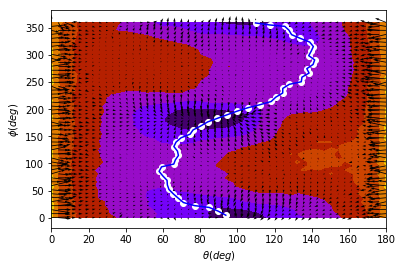



Barrier Height ($k_BT$):  2.49008942816
12499999
h= 1.78913553873
0.425762943712
0.916086543233
0.80994291434
0.476194450033
0.599950841168
0.548930771338
0.605574462004
0.716140219023
0.7653855141
0.889986202154




FTS calculation with  50  images.

The method did not converge in  10000  steps.


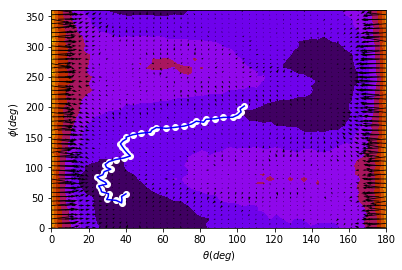



Barrier Height ($k_BT$):  0.514313251846
14285713
h= 1.56611067165
0.453336509771
0.529378870952
0.815334390451
0.505383660147
0.60750387479
0.567001699417
0.367787431924
0.389083392342
0.642065950674
0.623620830664




FTS calculation with  50  images.

The method did not converge in  10000  steps.


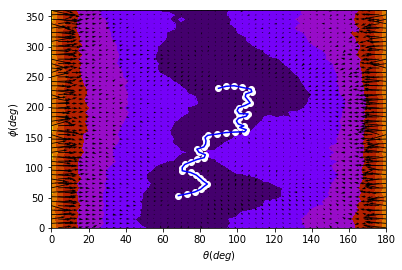



Barrier Height ($k_BT$):  0.715246830702
16071427
h= 1.46788398376
0.497406802578
0.712249802476
0.581078718972
0.290865048885
0.587598721215
0.44165490096
0.63203912277
0.465424545452
0.63444089062
0.46890053575




FTS calculation with  50  images.

The method did not converge in  10000  steps.


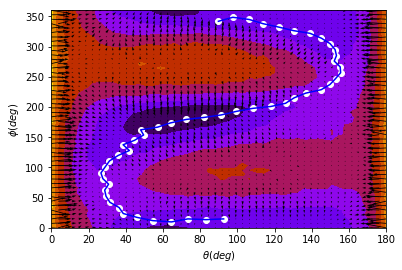



Barrier Height ($k_BT$):  1.50020785727
17857141
h= 1.83480194177
0.272797419417
0.47817037263
0.456896165461
0.639745027975
0.625148903677
0.45658829421
0.753781878669
0.555570734509
0.591353564398
0.734498664265




FTS calculation with  50  images.

The method did not converge in  10000  steps.


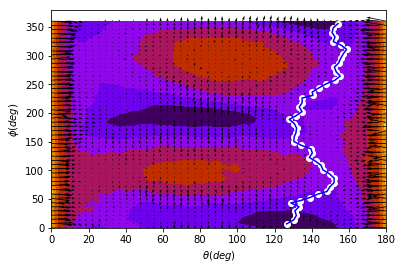



Barrier Height ($k_BT$):  1.43961171885
19642855
h= 1.65403718386
0.409546871736
0.392546359638
0.816402833129
0.353444780823
0.386341514807
0.74524065353
0.90956357562
0.545280758949
0.423473212062
0.687548845485




FTS calculation with  50  images.

The method did not converge in  10000  steps.


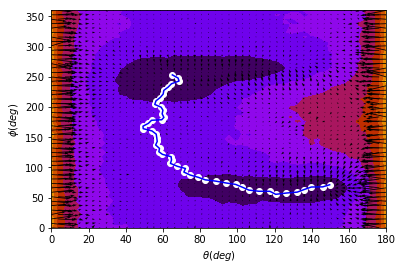



Barrier Height ($k_BT$):  0.877378407359
21428569
h= 1.66327600001
0.30143516728
0.39992499987
0.36751838551
0.895798511744
0.654629798587
0.744086686439
0.746338964413
0.883743434083
0.389830825009
0.65445601795




FTS calculation with  50  images.

The method did not converge in  10000  steps.


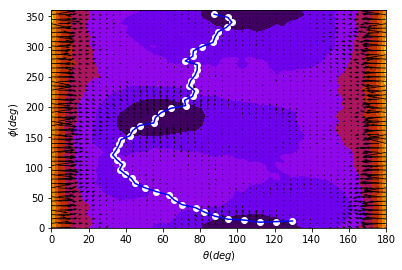



Barrier Height ($k_BT$):  1.45846298582
23214283
h= 1.64828245913
0.385120987259
0.737658554729
0.518508240297
1.11768554222
0.699361193307
0.81570092862
0.676203562649
0.467533984631
0.542282713741
0.828837959604




FTS calculation with  50  images.

The method did not converge in  10000  steps.


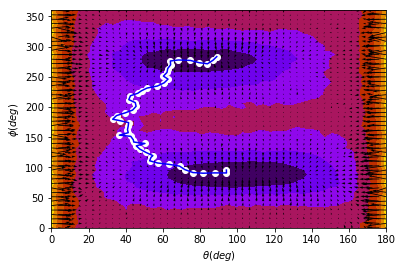



Barrier Height ($k_BT$):  1.81265297351
24999997
h= 1.52378164866
0.352204734627
0.860518285527
0.85701363712
1.09990731066
0.681409886614
0.553304519048
0.536147690925
0.351471412384
0.477165194618
0.764838891836




FTS calculation with  50  images.

The method did not converge in  10000  steps.


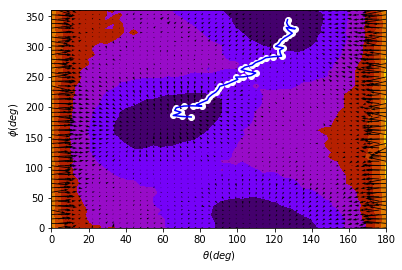



Barrier Height ($k_BT$):  1.50175537911
26785711
h= 1.50674797359
0.356371806955
0.648219865905
0.43354236107
0.533924270069
0.601291421239
0.879014735672
0.75222259133
0.801407422798
0.548303973222
0.68897492555




FTS calculation with  50  images.

The method did not converge in  10000  steps.


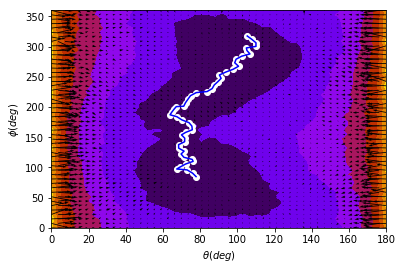



Barrier Height ($k_BT$):  0.58130714096
28571425
h= 1.0275263815
0.432903048154
0.483743333989
0.303211411697
0.497071411993
0.590001700913
0.467036672972
0.5517684294


In [ ]:
path="/home/ebeyerle/Desktop/PCA/UBQN/400ns/"
os.chdir(path)
bins=50
xx,yy=np.meshgrid(np.linspace(0,180,bins),np.linspace(0,360,bins))
#mode=1
nfrs=1
nframes=50
kT=0.5 #Unitless temperature
barlist=[]
pointslist=[]
for mode in range(1,229):
    with open(path+'anly_'+str(mode)+'.dat','r') as data:
        x=[]
        y=[]
        for line in data:
            nfrs=nfrs+1
            p=line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))
    print(nfrs)
    data=[np.column_stack([x,y])]
    model = mm.MSM(data)
    his0 = model.histogram(0, bins=50)
    his1 = model.histogram(1, bins=50)
    his = model.histogram(bins=50)
    ext=model.extent
    lst=np.zeros(bins*bins)
    chk=his.T/his.sum()
    counter=-1
    for i in range(len(chk[0,:])):
        for j in range(len(chk[:,0])):
            counter=counter+1
            lst[counter]=chk[i][j]
    counter=0
    fes=np.zeros((bins,bins))
    for i in range(len(chk[0,:])):
        for j in range(len(chk[:,0])):
            if (lst[counter] <= 0):
                fes[i][j]=-np.log(1/nfrs)
                counter=counter+1
            else:
                fes[i][j]=-np.log(lst[counter])
                counter=counter+1
    #plt.contourf(xx,yy,fes, 25, cmap='gnuplot')
    #plt.show()
    theta=np.linspace(0,180,bins)
    phi=np.linspace(0,360,bins)
    #fig=plt.figure(figsize=(12,8))
    dVy,dVx=np.gradient(fes)
    dVx=interpolate.interp2d(theta,phi,dVx,kind='quintic')
    dVy=interpolate.interp2d(theta,phi,dVy,kind='quintic')
    plt.close()
    plt.contourf(xx,yy,fes,cmap='gnuplot')
    plt.xlabel(r'$\theta (deg)$')
    plt.ylabel(r'$\phi (deg)$')
    plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
    #plt.show()
    #Now convert the code from the ZTS Matlab code
    tol1=0.00001 #Convergence criterion
    tollist=[]
    flag1=1
    nstepplot=1000
    nstep=10000
    g1=np.linspace(0,1,nframes)
    #Perform the interpolation; same as above
    min1=np.min(fes)
    for i in range(bins):
        for j in range(bins):
            fes[i][j]=fes[i][j]-min1
    min1=np.where(fes == 0.0)
    ya=y[0]
    xa=x[0]
    xb=x[-1]
    yb=y[-1]
    x=(xb-xa)*g1+xa
    y=(x-xa)*(yb-ya)/(xb-xa)+ya
    dx=x-np.roll(x,1,axis=0)
    dy=y-np.roll(y,1,axis=0)
    dx[0]=0
    dy[0]=0
    lxy=np.cumsum(np.sqrt(dx**2+dy**2))
    lxy=lxy/lxy[nframes-1]
    #Honestly not sure why these two lines are here; the x, y that are returned
    #are identical to the x, y generated by the linear interpolation.
    x=interpolate.interp1d(lxy,x)(g1)
    y=interpolate.interp1d(lxy,y)(g1)
    xi=x
    yi=y
    #plt.plot(xi,yi,'w',lw=1)
    plt.scatter(xi,yi,marker='x',c='w')
    plt.plot(x,y,'b')
    counter=1
    #plt.savefig("/home/ebeyerle/Desktop/fifty_fes_animate_mode"+str(mode)+"frame00"+str(counter)+".jpeg")
    plt.close()
    #plt.show()
    laplist=[]
    grady,gradx=np.gradient(fes)
    lapxy,lapxx=np.gradient(gradx)
    lapyy,lapyx=np.gradient(grady)
    h=1/(np.array([lapxx.max(),lapxy.max(),lapyx.max(),lapyy.max()]).max())
    n_strings=10
    #h=0.1#Just a parameter -- proabably need to adjust to get good convergence
    print('h=',h)
    for k in range(nstep):
        etax=np.random.randn(1,nframes)
        etay=np.random.randn(1,nframes)
        dVy,dVx=np.gradient(fes)
        dVx=interpolate.interp2d(theta,phi,dVx,kind='quintic')
        dVy=interpolate.interp2d(theta,phi,dVy,kind='quintic')
        x0=x
        y0=y
        # Evolve the string using steepest descent
        xstrings=x+np.random.normal(scale=np.sqrt(2*h*kT),size=(n_strings,nframes))
        ystrings=y+np.random.normal(scale=np.sqrt(2*h*kT),size=(n_strings,nframes))
        #avgx=[]
        #avgy=[]
        sumx=np.zeros(len(x))
        sumy=np.zeros(len(y))
        for j in range(len(x)):
            for i in range(n_strings):
                xstrings[i][j]=xstrings[i][j]-h*dVx(xstrings[i][j],ystrings[i][j])[0]+np.sqrt(2*h*kT)*etax[0][j]
                ystrings[i][j]=ystrings[i][j]-h*dVy(xstrings[i][j],ystrings[i][j])[0]+np.sqrt(2*h*kT)*etay[0][j]
                #Enforce PBCs
                #KLUDGE: Not letting them cross for now
                if ystrings[i][j] <=0.0: 
                    ystrings[i][j]=0.0
                if ystrings[i][j] >=360.0:
                    ystrings[i][j]=360.0
                if xstrings[i][j] <=0.0:
                    xstrings[i][j] = 0.0
                if xstrings[i][j] >= 180.0:
                    xstrings[i][j]=180.0
                sumx[j]=sumx[j]+xstrings[i][j]
                sumy[j]=sumy[j]+ystrings[i][j]
            sumx[j]=sumx[j]/n_strings
            sumy[j]=sumy[j]/n_strings
            #avgx.append(sumx[j])
            #avgy.append(sumy[j])
        x=sumx#np.array(avgx)
        y=sumy#np.array(avgy)
        #Reparameterize
        dx=x-np.roll(x,1,axis=0)
        dy=y-np.roll(y,1,axis=0)
        dx[0]=0
        dy[0]=0
        #Find the string length...
        lxy=np.cumsum(np.sqrt(dx**2+dy**2))
        lxy=lxy/lxy[nframes-1]
        #...and place each state at an equally-spaced length along the string
        x=interpolate.interp1d(lxy,x)(g1)
        y=interpolate.interp1d(lxy,y)(g1)
        #if flag1 == 1 and i%nstepplot == 0:
        #    counter=counter+1
            #plt.plot(x,y)
        #    if counter < 10:
        #        plt.contourf(xx,yy,fes,cmap='gnuplot')
        #        plt.xlabel(r'$\theta (deg)$')
        #        plt.ylabel(r'$\phi (deg)$')
        #        plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
        #        plt.scatter(x,y,marker='o',c='w')
        #        plt.plot(x,y,'b')
                #plt.savefig("/home/ebeyerle/Desktop/FTS_animate_mode"+str(mode)+"frame00"+str(counter)+".jpeg")
        #        plt.close()
        #    elif counter >= 10 and counter <100:
        #        plt.contourf(xx,yy,fes,cmap='gnuplot')
        #        plt.xlabel(r'$\theta (deg)$')
        #        plt.ylabel(r'$\phi (deg)$')
        #        plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
        #        plt.scatter(x,y,marker='o',c='w')
        #        plt.plot(x,y,'b')
                #plt.savefig("/home/ebeyerle/Desktop/FTS_animate_mode"+str(mode)+"frame0"+str(counter)+".jpeg")
        #        plt.close()
        #    else:
        #        plt.contourf(xx,yy,fes,cmap='gnuplot')
        #        plt.xlabel(r'$\theta (deg)$')
        #        plt.ylabel(r'$\phi (deg)$')
        #        plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
        #        plt.scatter(x,y,marker='o',c='w')
        #        plt.plot(x,y,'b')
                #plt.savefig("/home/ebeyerle/Desktop/FTS_animate_mode"+str(mode)+"frame"+str(counter)+".jpeg")
        #        plt.close()
        #    plt.show()
        tol=(np.linalg.norm(x-x0)+np.linalg.norm(y-y0))/(nframes)
        tollist.append(tol)
        #if len(tollist) >=3:
        #    if tollist[i-3]-tollist[i] == 0:
        #        print('converged')
        #        break
        if tol <= tol1: #Has the string converged?
            break #It has converged!
        if k%nstepplot == 0:
            print(tol)
    print('\n')
    print('\n')
    print('FTS calculation with ',nframes,' images.\n')
    if tol >= tol1:
        print('The method did not converge in ',nstep,' steps.')
    else:
        print('The method converged after ',nstep,' steps.')
    #plt.plot(x,y)
    plt.contourf(xx,yy,fes,cmap='gnuplot')
    plt.xlabel(r'$\theta (deg)$')
    plt.ylabel(r'$\phi (deg)$')
    plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
    plt.scatter(x,y,marker='o',c='w')
    plt.plot(x,y,'b')
    plt.show()
    #Generate tangent line
    tx=np.roll(x,-1,axis=0)-np.roll(x,1,axis=0)
    ty=np.roll(y,-1,axis=0)-np.roll(y,1,axis=0)
    #Use trapezoidal integration
    from scipy import integrate
    Vz=integrate.cumtrapz(tx*dVx(x,y)+ty*dVy(x,y))
    Vz=0.5*Vz
    Vz=Vz-np.min(Vz)
    ntxy=np.sqrt(tx*tx+ty*ty)
    tx=tx/ntxy
    ty=ty/ntxy
    err=np.trapz(1-(tx*dVx(x,y)+ty*dVy(x,y))**2/(dVx(x,y)*dVx(x,y)+dVy(x,y)*dVy(x,y))/nframes)
    print('\n')
    #print('Estimate of the difference between the discretized MEP and the actual MEP: ',err,'.')
    #Plot the 1D FES along the string
    ifes=interpolate.interp2d(theta,phi,fes,kind='quintic')
    points=[]
    for i in range(len(x)):
        points.append(ifes(x[i],y[i])[0])
        #print(points[i])
    pointslist.append(points)
    np.savetxt("points"+str(mode),points)
    np.savetxt("coords_"+str(mode)+".dat",np.column_stack([x,y]))
    %matplotlib inline
    plt.plot(points,'k')
    plt.xlabel('Image Number')
    plt.ylabel('free energy ($k_BT$)')
    bar=np.max(np.array(points))-np.min(np.array(points))
    print('Barrier Height ($k_BT$): ',bar)
    barlist.append(bar)
    np.savetxt("barlist.dat",np.array(barlist))
    np.savetxt("coords_"+str(mode)+".dat",np.column_stack([x,y]))